# Imports, Image Loaders, and Visualization

Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import time
import os
import functools
import IPython.display as display

Image Loading & Preprocessing

In [2]:
# Image load and processing utilities
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = tf.clip_by_value(tensor, 0, 255)
    tensor = tf.cast(tensor, tf.uint8)
    return PIL.Image.fromarray(tensor.numpy()[0])

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.axis('off')
    plt.imshow(image)
    if title:
        plt.title(title)

Load Content and Style Images

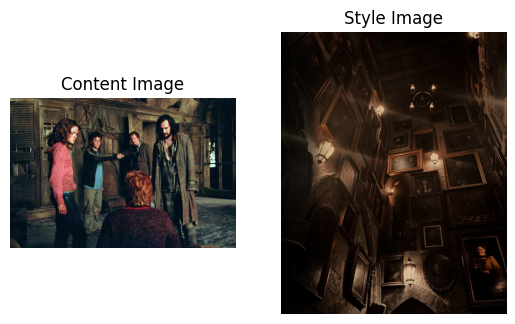

In [3]:
# Replace with your own image paths
'''
content_path = tf.keras.utils.get_file('content_img.jpg', origin='')
style_path = tf.keras.utils.get_file('style_img.jpg', origin='')
'''

content_path = 'harry_potter.jpg'
style_path = 'style3.jpg'


content_image = load_img(content_path)
style_image = load_img(style_path)

# Visualize
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


# Feature Extraction with VGG19

- Load a pre-trained VGG19 model.
- Extract outputs from intermediate layers:
    - Content Layer: captures structural information.
    - Style Layers: capture textures and patterns.

Choose Layers

In [4]:
# Layers for content and style representation
content_layers = ['block5_conv2']  # Deeper layer = better content structure

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]  # Shallow + deep = rich style info

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Build the VGG Model

In [5]:
def vgg_layers(layer_names):
    '''Creates a VGG19 model that returns a list of intermediate output values.'''
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False  # Freeze model

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

Extract Style and Content Features

In [6]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg_preprocessing = tf.keras.applications.vgg19.preprocess_input

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = self.vgg_preprocessing(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [self.gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

    def gram_matrix(self, input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result / num_locations


# Define Style Loss, Content Loss, and Total Loss

The loss is made up of:
- Style Loss: Measures how close the generated image's style is to the style image.
- Content Loss: Measures how well the generated image preserves content from the original.
- Total Loss: Weighted sum of style + content loss.

Total Loss Function
- `style_weight = 1e-2`: keeps textures subtle.
- `content_weight = 1e4`: keeps structure strong.

In [7]:
def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

# Training Loop — Optimize the Stylized Image
- Use `tf.GradientTape` for custom training.
- Optimize the image itself (not the model).

Training Step Function

In [8]:
@tf.function()
def train_step(image, extractor, style_targets, content_targets, optimizer, style_weight, content_weight):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

Training Loop with Progress and Visualization

In [9]:
def run_style_transfer(content_path, style_path,
                       num_epochs=10, steps_per_epoch=100,
                       style_weight=1e-2, content_weight=1e4):
    # content_image = load_img(content_path)
    # style_image = load_img(style_path)

    extractor = StyleContentModel(style_layers, content_layers)

    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']

    # Create generated image variable
    image = tf.Variable(content_image)

    # Define optimizer
    optimizer = tf.optimizers.Adam(learning_rate=0.02)

    for n in range(num_epochs):
        for m in range(steps_per_epoch):
            train_step(image, extractor, style_targets, content_targets, optimizer, style_weight, content_weight)
        print(f"Epoch {n+1} completed.")

    return image


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 511, 409, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 341, 512, 3))
  warnings.warn(msg)


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.


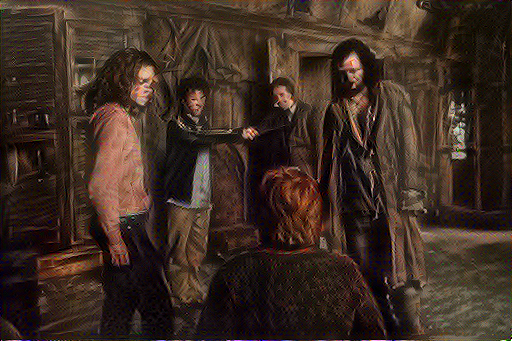

In [10]:
stylized_image = run_style_transfer(content_path, style_path)

result = tensor_to_image(stylized_image)
display.display(result)

In [11]:
file_name = 'stylized-image1.png'
result.save(file_name)

try:
  from google.colab import files
  files.download(file_name)
except (ImportError, AttributeError):
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>